In [1]:
import json
import glob
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import statistics
import numpy as np
import operator
import matplotlib.ticker as plticker
import os
from pathlib import Path
import shutil

In [2]:
eval_files_list = [Path(pth) for pth in glob.glob('**/eval_results*.json', recursive=True)]

In [3]:
def get_data(eval_file_path):
    with open(eval_file_path, 'r') as f:
        data = json.loads(f.read())
    eval_data = {}
    eval_data["iteration"] = data["config"]["model_args"]["iteration"]
    eval_data["model_name"] = list(data["config"]["model_args"]["config_files"].keys())[0][:-4]
    eval_data["folder"] = str(eval_file_path.parent.parts[0])
    eval_data["file_name"] = str(eval_file_path.name)
    if eval_data["folder"].startswith("intervene"):
        if eval_data["folder"].endswith("_7"):
            eval_data["model_name"] += "_int_7"
        elif eval_data["folder"].endswith("21"):
            eval_data["model_name"] += "_int_21"
    eval_data["templates"] = tuple(set(data["table_results"][res]["prompt_name"] for res in data["table_results"].keys()))
    eval_data["tasks"] = tuple(set(data["table_results"][res]["task_name"] for res in data["table_results"].keys()))
    dct = defaultdict(list)
    for key, value in data["table_results"].items():
        task, template = key.split("+")
        dct[task].append((template, value["em"], value["em_stderr"]))
    for template, value in dct.items():
        inner_dict = {}
        for task, em, em_stderr in value:
            inner_dict[task] = (em, em_stderr)
        dct[template] = inner_dict
    eval_data["results"] = dct
    return eval_data

In [4]:
data_lst = [get_data(eval_file_path) for eval_file_path in eval_files_list]

In [14]:
tasks = ["wino_bias_type1_pro", "wino_bias_type1_anti", "wino_bias_type2_pro", "wino_bias_type2_anti"]
templates = ["What does p stand for", "refers_to"]
model_sizes_dct = {
    "19M": "Pythia 70M",
    "19M_int_7": "Intervention 70M",
    "350M": "Pythia 410M",
    "350M_int_7": "Intervention 410M",
    "1.3B": "Pythia 1.4B",
    "1.3B_int_7": "Intervention 1.4B",
    "1.3B_int_21": "Long intervention 1.4B",
    "6.7B": "Pythia 6.9B",
    "6.7B_int_7": "Intervention 6.9B",    
    }
model_sizes = list(model_sizes_dct.keys()) + [size + "_int_7" for size in list(model_sizes_dct.keys())] + ["1.3B_int_21"]
bb_iterations = sorted([eval["iteration"] for eval in data_lst 
        if not eval["folder"].startswith("intervene")
        and eval["model_name"] == "pythia-350M"])
bb_int_iterations = sorted([eval["iteration"] for eval in data_lst 
        if eval["folder"].startswith("intervene")
        and eval["model_name"].startswith("pythia-350M")])
sb_iterations = sorted([eval["iteration"] for eval in data_lst 
        if not eval["folder"].startswith("intervene")
        and eval["model_name"] == "pythia-6.7B"])
sb_int_iterations = sorted([eval["iteration"] for eval in data_lst 
        if eval["folder"].startswith("intervene")
        and eval["model_name"].startswith("pythia-6.7B")])
sb_bigint_iterations = sorted([eval["iteration"] for eval in data_lst
                               if eval["folder"].startswith("intervene")
                               and eval["model_name"].startswith("pythia-1.3B_int_21")])
iter_percents = [float("{:.1f}".format((iter / bb_iterations[-1]) * 100)) for iter in bb_iterations]
iter_percents_int_7 = [float("{:.1f}".format((iter / bb_int_iterations[-1]) * 100)) for iter in bb_int_iterations]
iter_percents_int_21 = [float("{:.1f}".format((iter / sb_bigint_iterations[-1]) * 100)) for iter in sb_bigint_iterations]

In [6]:
def eval_model_size(model_size):
    # return dict is a dict of dicts, where the first keys are the iterations
    # and the second keys are "type1" and "type2"
    proc_dct = {}
    final_results = {}
    if "int" in model_size:
        model_name = "test"
    for eval in data_lst:
        iteration = eval["iteration"]
        proc_dct[iteration] = {
            task: {} for task in tasks
        }
        if eval["model_name"] == f"pythia-{model_size}":
            for task, result_dct in eval["results"].items():
                mean = statistics.fmean([result_dct[template][0] for template in templates])
                std = math.sqrt(statistics.mean([result_dct[template][1]**2 for template in templates]))
                proc_dct[iteration][task] = (mean, std)
            type1_diff = proc_dct[iteration]["wino_bias_type1_pro"][0] - proc_dct[iteration]["wino_bias_type1_anti"][0]
            # Std of difference is sqrt(sum of variances)
            type1_err = math.sqrt(proc_dct[iteration]["wino_bias_type1_pro"][1]**2 + proc_dct[iteration]["wino_bias_type1_anti"][1]**2)
            type1_pro, type1_anti = proc_dct[iteration]["wino_bias_type1_pro"][0], proc_dct[iteration]["wino_bias_type1_anti"][0]
            type2_diff = proc_dct[iteration]["wino_bias_type2_pro"][0] - proc_dct[iteration]["wino_bias_type2_anti"][0]
            type2_err = math.sqrt(proc_dct[iteration]["wino_bias_type2_pro"][1]**2 + proc_dct[iteration]["wino_bias_type2_anti"][1]**2)
            type2_pro, type2_anti = proc_dct[iteration]["wino_bias_type2_pro"][0], proc_dct[iteration]["wino_bias_type2_anti"][0]
            type1 = (type1_diff, type1_err, type1_pro, type1_anti)
            type2 = (type2_diff, type2_err, type2_pro, type2_anti)
            final_results[iteration] = {
                "type1": type1,
                "type2": type2 
            }
    return final_results

In [7]:
all_results = {size: eval_model_size(size) for size in model_sizes}

In [8]:
def get_lists_for_plotting(model_size, type):
    res_lists = {
        "diffs": [],
        "errs": [],
        "pro": [],
        "anti": [],
    }
    if model_size == "19M" or model_size == "6.7B":
        iterations = sb_iterations
    elif model_size.endswith("int_7"):
        if model_size.startswith("19M") or model_size.startswith("6.7B"):
            iterations = sb_int_iterations
        else:
            iterations = bb_int_iterations
    elif model_size.endswith("int_21"):
        iterations = sb_bigint_iterations
    else:
        iterations = bb_iterations
    for iteration in iterations:
        diff, err, pro_em, anti_em = all_results[model_size][iteration][type]
        res_lists["diffs"].append(diff)
        res_lists["errs"].append(err)
        res_lists["pro"].append(pro_em)
        res_lists["anti"].append(anti_em)
    return res_lists

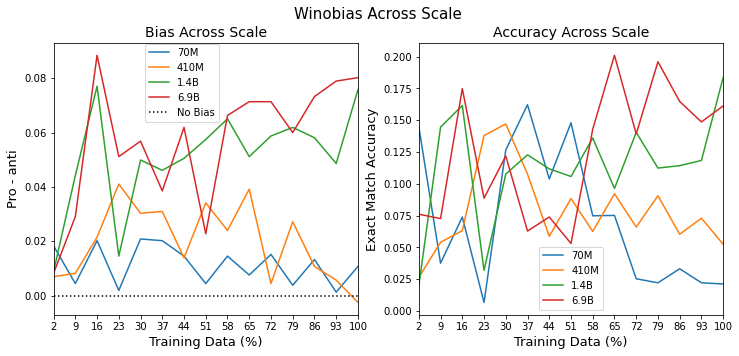

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for size in model_sizes:
    type1 = get_lists_for_plotting(size, "type1")
    type2 = get_lists_for_plotting(size, "type2")
    pro = np.mean([type1["pro"], type2["pro"]], axis=0)
    anti = np.mean([type1["anti"], type2["anti"]], axis=0)
    diff = pro - anti
    ax[0].plot(iter_percents, diff, label=model_sizes_dct[size])
    ax[1].plot(iter_percents, np.mean([pro, anti], axis=0), label=model_sizes_dct[size])

ax[0].plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")

for i in range(len(ax)):
    ax[i].set_xlabel("Training Data (%)", fontsize=13)
    if i == 0:
        ax[i].legend(loc=(0.30, 0.71))
        ax[i].set_ylabel("Pro - anti", fontsize=13)
        metric_str = "Bias"
    else:
        ax[i].legend(loc="lower center")
        ax[1].set_ylabel("Exact Match Accuracy", fontsize=13)
        metric_str = "Accuracy"
    ax[i].title.set_text(f'{metric_str} Across Scale')
    ax[i].title.set_fontsize(14)
    ax[i].set_xlim(0, 14)

fig.suptitle("Winobias Across Scale", fontsize=15)
for i in range(len(ax)):
    ax[i].set_xlim(0, 14)
fig.savefig("winobias_scale.pdf")

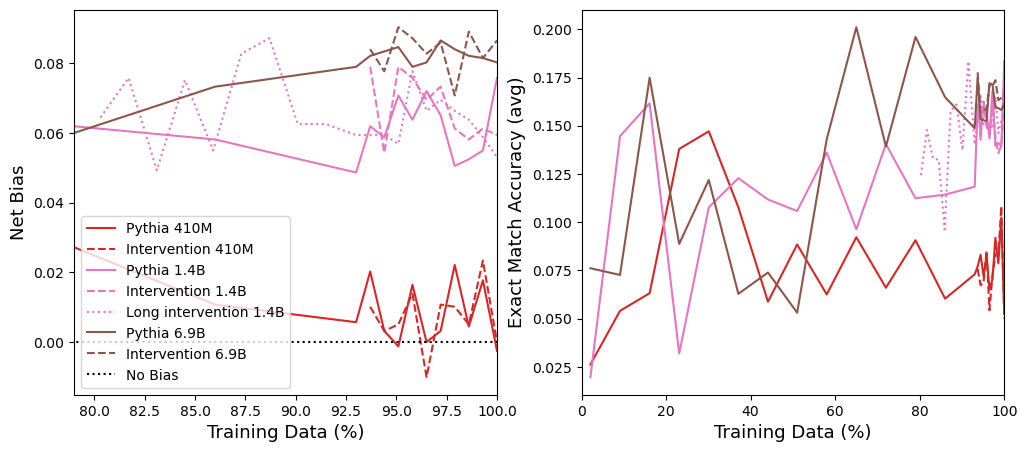

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for size in ["350M", "350M_int_7", "1.3B", "1.3B_int_7", "1.3B_int_21", "6.7B", "6.7B_int_7"]:
    type1 = get_lists_for_plotting(size, "type1")
    type2 = get_lists_for_plotting(size, "type2")
    pro = np.mean([type1["pro"], type2["pro"]], axis=0)
    anti = np.mean([type1["anti"], type2["anti"]], axis=0)
    diff = pro - anti
    percents = iter_percents
    if size.endswith("int_7"):
        percents = iter_percents_int_7
    elif size.endswith("int_21"):
        percents = iter_percents_int_21
    linestyle = "solid"
    colours = {
        "19M": "C4",
        "350M": "C3",
        "1.3B": "C6",
        "6.7B": "C5",
    }
    label = " ".join(model_sizes_dct[size].split("_"))
    if size.endswith("int_7"):
        linestyle = "dashed"
    if size.endswith("int_21"):
        linestyle = "dotted"
    ax[0].plot(percents, diff, label=label, linestyle=linestyle,
                  color=colours[size.split("_")[0]])
    ax[1].plot(percents, np.mean([pro, anti], axis=0), label=label, 
                  linestyle=linestyle, color=colours[size.split("_")[0]])

ax[0].plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")
ax[0].set_xlabel("Training Data (%)", fontsize=13)
ax[0].legend() #loc=(0.30, 0.71))
ax[0].set_ylabel("Net Bias", fontsize=13)
metric_str = "Bias"
#ax[0].title.set_text(f'{metric_str} Across Scale')
#ax[0].title.set_fontsize(14)
ax[0].set_xlim(79, 100)

ax[1].set_xlabel("Training Data (%)", fontsize=13)
#ax[1].legend() #loc=(0.30, 0.71))
ax[1].set_ylabel("Exact Match Accuracy (avg)", fontsize=13)
metric_str = "Accuracy"
#ax[1].title.set_text(f'{metric_str} Across Scale (avg)')
#ax[1].title.set_fontsize(14)
ax[1].set_xlim(0, 100)

fig.savefig("winobias_scale_final.pdf")

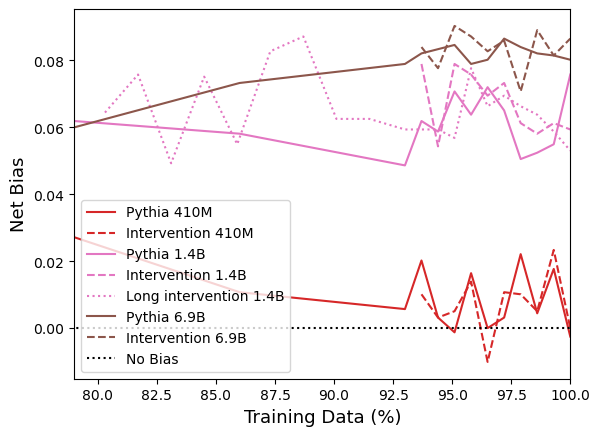

In [29]:
fig, ax = plt.subplots((1, 2))
for size in ["350M", "350M_int_7", "1.3B", "1.3B_int_7", "1.3B_int_21", "6.7B", "6.7B_int_7"]:
    type1 = get_lists_for_plotting(size, "type1")
    type2 = get_lists_for_plotting(size, "type2")
    pro = np.mean([type1["pro"], type2["pro"]], axis=0)
    anti = np.mean([type1["anti"], type2["anti"]], axis=0)
    diff = pro - anti
    percents = iter_percents
    if size.endswith("int_7"):
        percents = iter_percents_int_7
    elif size.endswith("int_21"):
        percents = iter_percents_int_21
    linestyle = "solid"
    colours = {
        "350M": "C3",
        "1.3B": "C6",
        "6.7B": "C5",
    }
    if size.endswith("int_7"):
        linestyle = "dashed"
    if size.endswith("int_21"):
        linestyle = "dotted"
    ax.plot(percents, diff, label=model_sizes_dct[size], linestyle=linestyle,
                  color=colours[size.split("_")[0]])

ax.plot(iter_percents, [0 for _ in iter_percents], linestyle=":", color="black", label="No Bias")
ax.set_xlabel("Training Data (%)", fontsize=13)
ax.legend(loc="lower left")
ax.set_ylabel("Net Bias", fontsize=13)
metric_str = "Bias"
ax.set_xlim(79, 100)

fig.savefig("winobias_scale_final.pdf")